# WIP : OM4 SST Bias Calculation

Credit: https://github.com/Pperezhogin/MOM6/blob/Zanna-Bolton-2020/experiments/ZB20-Results/14-Global-presentation.ipynb

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import (
    remesh,
    gaussian_remesh,
    select_LatLon,
    Lk_error,
    x_coord,
    y_coord,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs

hvplot.output(widget_location="bottom")

# SST bias

In [2]:
import xarray as xr

store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/WOA_1degree_monthly-feedstock/woa18-1deg-monthly.zarr"
ds = xr.open_dataset(store, engine="zarr", chunks={})
obsT = ds.t_an.isel(depth=0).mean("time").compute()

In [3]:
ds

<xarray.Dataset>
Dimensions:             (time: 12, depth: 57, lat: 180, lon: 360, nbounds: 2)
Coordinates:
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    crs                 int32 ...
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(57, 2), meta=np.ndarray>
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time                (time) object 1958-01-16 00:00:00 ... 1958-12-16 00:0...
Dimensions without coordinates: nbounds
Data variables: (12/40)
    A_an                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    A_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    A_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    A_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    A_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    A_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    ...                  ...
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    t_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(12, 57, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    cdm_data_type:                   Grid
    comment:                         global climatology as part of the World ...
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    creator_email:                   NCEI.info@noaa.gov
    ...                              ...
    summary:                         Climatological mean Apparent Oxygen Util...
    time_coverage_duration:          P!!Y
    time_coverage_end:               2017-01-31
    time_coverage_resolution:        P01M
    time_coverage_start:             1900-01-01
    title:                           World Ocean Atlas 2018 : Apparent_Oxygen...

In [9]:
obsT["lon"] = np.where(obsT["lon"] > 0, obsT["lon"], 360 + obsT["lon"])
obsT = obsT.sortby("lon")

In [10]:
path = "gs://leap-persistent/jbusecke/OM4_m2lines/daily_combined.zarr"
ds = xr.open_dataset(path, engine="zarr", chunks={})
ds

<xarray.Dataset>
Dimensions:       (yq: 1081, xq: 1441, yh: 1080, xh: 1440, experiment: 2,
                   time: 1827, nv: 2)
Coordinates: (12/34)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(270, 360), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(270, 361), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(271, 360), meta=np.ndarray>
    basin         (yh, xh) int32 dask.array<chunksize=(270, 360), meta=np.ndarray>
    ...            ...
    wet_u         (yh, xq) float32 dask.array<chunksize=(270, 361), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(271, 360), meta=np.ndarray>
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    average_DT    (experiment, time) timedelta64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T1    (experiment, time) datetime64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T2    (experiment, time) datetime64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    ssu           (experiment, time, yh, xq) float32 dask.array<chunksize=(1, 20, 1080, 1441), meta=np.ndarray>
    ssv           (experiment, time, yq, xh) float32 dask.array<chunksize=(1, 20, 1081, 1440), meta=np.ndarray>
    time_bnds     (experiment, time, nv) object dask.array<chunksize=(2, 1827, 2), meta=np.ndarray>
    tos           (experiment, time, yh, xh) float32 dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
    zos           (experiment, time, yh, xh) float32 dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 20080101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_bugfixes_JRA55do1.5_cycle1

In [11]:
ds_ZB = ds.sel(experiment="ZB2020")
ds_om4 = ds.sel(experiment="unparameterized")

In [12]:
### Need to get this
# ds_ZB = xr.open_mfdataset('/vast/pp2681/ZB2020/ocean_monthly/*', decode_times=False).isel(time=slice(276,636)) # time slice corresponds to 1981-2010
# ds_om4 = xr.open_mfdataset('/vast/pp2681/unparameterized/annual/5yr/*').isel(time=slice(23,48))
# om4T = ds_om4.thetao.isel(z_l=0).mean('time').compute()
# ZBT = ((ds_ZB.average_DT*ds_ZB.thetao.isel(z_l=0)).sum('time') / ds_ZB.average_DT.sum('time')).compute()

In [13]:
ZBT = ds_ZB["tos"]
om4T = ds_om4["tos"]

In [15]:
print(obsT.shape)
print(om4T.shape)
print(ZBT.shape)

(180, 360)
(1827, 1080, 1440)
(1827, 1080, 1440)


In [8]:
bias_om4 = om4T - obsT
bias_om4 = xr.where(np.isnan(obsT), np.nan, bias_om4)

In [9]:
bias_ZB = ZBT - obsT
bias_ZB = xr.where(np.isnan(bias_om4), np.nan, bias_ZB)

In [10]:
response_ZB = ZBT - om4T
response_ZB = xr.where(np.isnan(bias_om4), np.nan, response_ZB)

In [11]:
fraction = np.abs(bias_ZB) / np.abs(bias_om4)
fraction = xr.where(np.isnan(bias_om4), np.nan, fraction)

ValueError: DataArray must be 2d

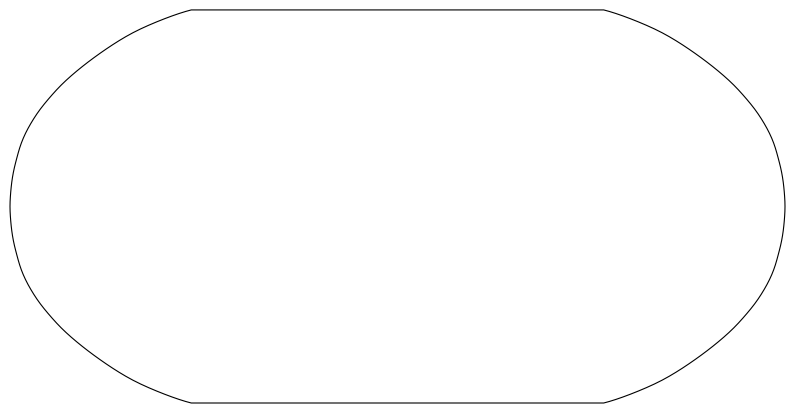

In [12]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1,
    1,
    figsize=(10, 7),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad("gray")
im = bias_om4.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    add_colorbar=False,
    vmin=-5,
    vmax=5,
    interpolation="none",
)


cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.57)
cb.set_label(label="$C^o$")
cb.ax.set_yticks([-5, 0, 5])
plt.title("OM4 SST bias, 1981-2010", fontsize=20)
plt.savefig("site-visit/OM4-SST-bias-cmocean.pdf", dpi=200)

ValueError: DataArray must be 2d

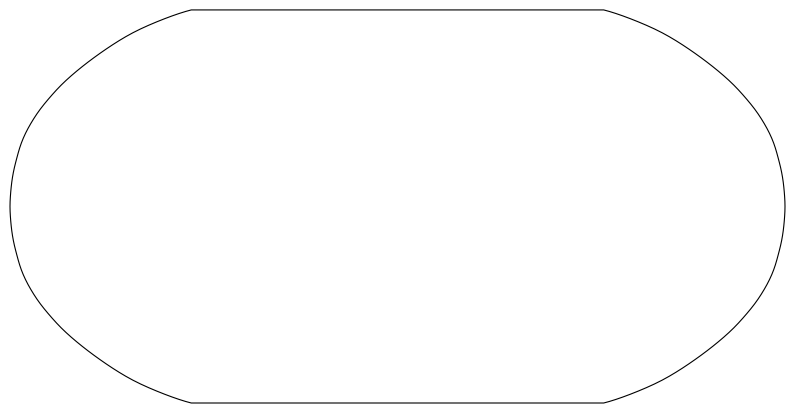

In [21]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1,
    1,
    figsize=(10, 7),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

ax = axes
# cmap = plt.get_cmap('seismic')
# cmap.set_bad('gray')
im = response_ZB.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    add_colorbar=False,
    vmin=-5,
    vmax=5,
    interpolation="none",
)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.57)
cb.set_label(label="$C^o$")
cb.ax.set_yticks([-5, 0, 5])
plt.title("ZB20 SST response", fontsize=20)
plt.savefig("site-visit/ZB-SST-bias-response-cmocean.pdf", dpi=200)

ValueError: DataArray must be 2d

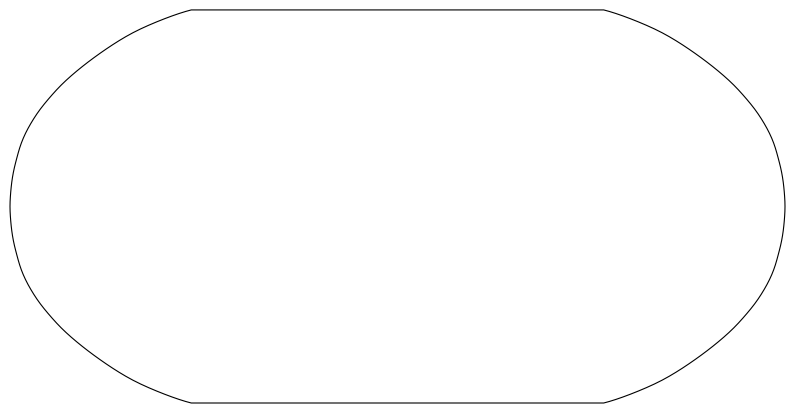

In [22]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1,
    1,
    figsize=(10, 7),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad("gray")
im = fraction.plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    add_colorbar=False,
    vmin=0,
    vmax=2,
    interpolation="none",
)


cb = plt.colorbar(im, pad=0.02, ax=axes, extend="max", aspect=20, shrink=0.57)
cb.set_label(label="")
cb.ax.set_yticks([0, 1, 2], ["0 (better)", "1 (same)", "2 (worse)"])
plt.title(
    "$\\frac{|\\mathrm{ZB20~ SST~ bias}|}{|\\mathrm{OM4~ SST ~bias}|}$", fontsize=30
)
plt.savefig("site-visit/OM4-bias-fraction.pdf", dpi=200)

ValueError: DataArray must be 2d

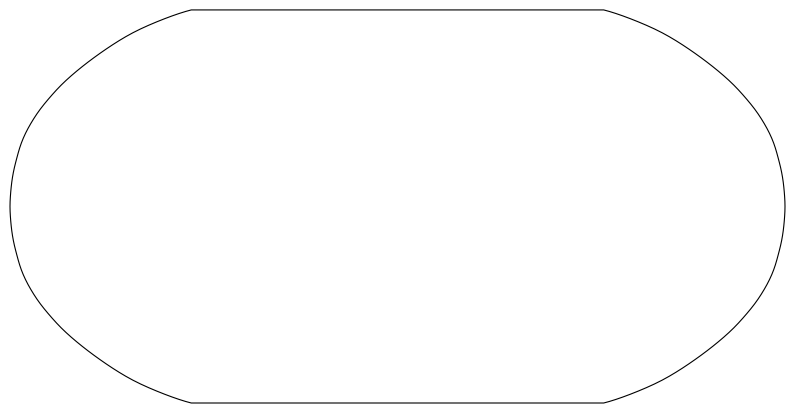

In [23]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1,
    1,
    figsize=(10, 7),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

ax = axes
cmap = plt.get_cmap("inferno")
cmap.set_bad("gray")
im = (np.abs(bias_om4 - bias_ZB)).plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    add_colorbar=False,
    vmin=0,
    vmax=3,
    interpolation="none",
)


cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.57)
cb.set_label(label="$C^o$")
plt.title("$|(\\mathrm{ZB20~ SST~ bias}) - (\\mathrm{OM4~ SST ~bias})|}$", fontsize=20)
plt.savefig("site-visit/OM4-bias-diff.pdf", dpi=200)

In [ ]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

lat = slice(20, 60)
lon = slice(260, 330)
fig, axes = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    subplot_kw={
        "projection": ccrs.Orthographic(
            central_latitude=(lat.start + lat.stop) / 2,
            central_longitude=(lon.start + lon.stop) / 2,
        )
    },
)

ax = axes
# cmap = plt.get_cmap('seismic')
# cmap.set_bad('gray')
im = bias_om4.sel(lat=lat, lon=lon).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5, vmax=5
)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.6)
cb.set_label(label="$C^o$")
cb.ax.set_yticks([-5, 0, 5])
plt.title("OM4 SST bias, 1981-2010", fontsize=25)
plt.savefig("site-visit/OM4-SST-bias-Atlantic-cmocean.pdf", dpi=200)

In [ ]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

lat = slice(20, 60)
lon = slice(260, 330)
fig, axes = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    subplot_kw={
        "projection": ccrs.Orthographic(
            central_latitude=(lat.start + lat.stop) / 2,
            central_longitude=(lon.start + lon.stop) / 2,
        )
    },
)

ax = axes
# cmap = plt.get_cmap('seismic')
# cmap.set_bad('gray')
im = response_ZB.sel(lat=lat, lon=lon).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5, vmax=5
)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.6)
cb.set_label(label="$C^o$")
cb.ax.set_yticks([-5, 0, 5])
plt.title("ZB20 SST response", fontsize=25)
plt.savefig("site-visit/ZB-SST-bias-response-Atlantic-cmocean.pdf", dpi=200)

In [ ]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

lat = slice(20, 60)
lon = slice(260, 330)
fig, axes = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    subplot_kw={
        "projection": ccrs.Orthographic(
            central_latitude=(lat.start + lat.stop) / 2,
            central_longitude=(lon.start + lon.stop) / 2,
        )
    },
)

ax = axes
cmap = plt.get_cmap("seismic")
cmap.set_bad("gray")
im = bias_ZB.sel(lat=lat, lon=lon).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5, vmax=5
)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend="both", aspect=20, shrink=0.6)
cb.set_label(label="$C^o$")
cb.ax.set_yticks([-5, 0, 5])
plt.title("ZB20 SST bias, 1981-2010", fontsize=25)
plt.savefig("site-visit/ZB-SST-bias-Atlantic.pdf", dpi=200)